
# Objetivo 2: Generación de modelos

Pipeline completo para la predicción del crecimiento de datos de biodiversidad en GBIF.

Este script implementa el flujo de trabajo de principio a fin para modelar datos de panel
de series temporales, incluyendo:
1.  Carga datos de PA_dataAnalysis y preparación
2.  Ingeniería de características temporales (lags y ventanas móviles).
3.  Un marco de validación cruzada robusto para series de tiempo (ventana expansiva).
4.  Preprocesamiento (imputación y escalado) dentro del bucle de validación para evitar fuga de datos.
5.  Entrenamiento y evaluación comparativa de cuatro modelos:
    - Prophet.
    - Random Forest.
    - XGBoost.
    - Red Neuronal LSTM (para modelado secuencial).

6.  Selección del mejor modelo basado en métricas de rendimiento (MAE, RMSE, R²).
7.  Reentrenamiento del modelo final y generación de pronósticos para Colombia hasta 2030
    bajo dos escenarios de políticas.

In [1]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

# Preprocesamiento y modelado de Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Modelos especializados

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Configuraciones generales
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

Importing plotly failed. Interactive plots will not work.


In [2]:
# Modelado de Deep Learning con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-10-05 16:30:55.489032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Carga de datos

url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
Data_final = pd.read_csv(url)

# Convertir 'year' a formato de fecha para Prophet
Data_final['ds'] = pd.to_datetime(Data_final['year'], format='%Y')

# Ordenar los datos por país y año para series de tiempo
Data_final = Data_final.sort_values(by=['country', 'ds']).reset_index(drop=True) # Falta ajustar para que la fecha sea al 31 de Diciembre de cada año

# Transformar el target ANTES de feature engineering
TARGET = 'occurrenceCount_publisher'
Data_final[TARGET] = np.log1p(Data_final[TARGET])  

print("Transformación log1p aplicada al target.")


# Eliminación de columnas por tener muchos vacíos y no ser posible completarlas con imputación. (pensar en otras estrategias)
columns_to_drop = ['Overall score', 'areas_protegidas']
Data_final = Data_final.drop(columns=columns_to_drop)

Transformación log1p aplicada al target.


Para aplicar modelos como Random Forest y XGBoost, es necesario agregar características de temporalidad en los datos, para lo cuál es necesario calcular retardos, que se deben aplicar teniendo en cuenta un análisis del ACF Y PACF, así como la incorporación de los tiempos del retardo como hiperparámetros. 

Los modelos basados en árboles como Random Forest y XGBoost no son conscientes de la secuencia temporal de los datos y no pueden "extrapolar" tendencias más allá de los valores que han visto en el entrenamiento. Por lo tanto, es necesario convertir la información temporal en características que el modelo pueda entender. La creación de retardos (lags) y estadísticas de ventana móvil es la técnica estándar para lograrlo. Se podría identificar el número de retardos como un hiperparámetro, guiado por análisis de ACF y PACF (Ver EDA)

In [5]:
# =============================================================================
# 2. INGENIERÍA DE CARACTERÍSTICAS TEMPORALES 
# =============================================================================


def create_temporal_features_optimized(data, features_to_lag, 
                                     lags=[], 
                                     roll_windows=[],
                                     fill_na=0):

    df_copy = data.copy()
    
    for feature in features_to_lag:
        for lag in lags:
            lag_col = f'{feature}_lag{lag}'
            df_copy[lag_col] = df_copy.groupby('country')[feature].shift(lag)
        
        for w in roll_windows:
            mean_col = f'{feature}_rollmean{w}'
            df_copy[mean_col] = (
                df_copy.groupby('country')[feature]
                .shift(1)
                .rolling(window=w, min_periods=1)
                .mean()
            )
            
            std_col = f'{feature}_rollstd{w}'
            df_copy[std_col] = (
                df_copy.groupby('country')[feature]
                .shift(1)
                .rolling(window=w, min_periods=1)
                .std()
            )

    return df_copy


In [6]:
# =============================================================================
# Uso del código optimizado (AJUSTADO: no se llenan con 0 los NaN)
# =============================================================================

# Aplicar rezagos en bloques. 
# NOTA: al generar lags/rolling se perderán observaciones iniciales por cada país. Esto es esperado, y deben tratarse después (ej. dropna o imputación).

features_to_lag = [
    "PC1", "PC2", "PC3", "PC4", "occurrenceCount_publisher"
]

# Crear dataset con nuevas features (manteniendo NaN))
df_featured = create_temporal_features_optimized(
    Data_final,
    features_to_lag=features_to_lag,
    lags=[1, 3, 5],   
    roll_windows=[1, 3, 5],   
    fill_na=None  # no se rellena con ceros
)

# Eliminar las filas que quedaron con NaN:
#df_featured = df_featured.dropna().reset_index(drop=True)

print("Ingeniería de características completada.")
print(f"Shape del dataset: {df_featured.shape}")
print(f"Valores NaN restantes: {df_featured.isnull().sum().sum()}")

# Mostrar estadísticas de las nuevas características
print("\nEstadísticas de las nuevas características:")
new_features = [col for col in df_featured.columns if any(x in col for x in ['_lag', '_roll'])]
print(df_featured[new_features].describe())


Ingeniería de características completada.
Shape del dataset: (656, 60)
Valores NaN restantes: 5360

Estadísticas de las nuevas características:
         PC1_lag1    PC1_lag3    PC1_lag5  PC1_rollmean1  PC1_rollstd1  \
count  615.000000  533.000000  451.000000     615.000000           0.0   
mean     0.041642    0.129046    0.195605       0.041642           NaN   
std      2.418907    2.430074    2.443053       2.418907           NaN   
min     -3.872488   -3.872488   -3.872488      -3.872488           NaN   
25%     -1.733051   -1.664656   -1.607699      -1.733051           NaN   
50%     -0.532817   -0.469703   -0.404598      -0.532817           NaN   
75%      1.507205    1.561587    1.695762       1.507205           NaN   
max      5.620231    5.620231    5.620231       5.620231           NaN   

       PC1_rollmean3  PC1_rollstd3  PC1_rollmean5  PC1_rollstd5    PC2_lag1  \
count     655.000000    654.000000     655.000000    654.000000  615.000000   
mean        0.043846      0.278

In [7]:
# =============================================================================
# 3. PREPARACIÓN DE DATOS PARA LOS MODELOS
# =============================================================================
# ✅ NUEVO BLOQUE: ESCALAMIENTO GLOBAL DE VARIABLES NUMÉRICAS
numeric_cols = df_featured.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler_global = StandardScaler()

df_featured_scaled = df_featured.copy()
df_featured_scaled[numeric_cols] = scaler_global.fit_transform(df_featured[numeric_cols])
print(f"Escalamiento global aplicado a {len(numeric_cols)} variables numéricas.")

TARGET = 'occurrenceCount_publisher'

# -------------------------------------------------------------------------
# A. RandomForest y XGBoost (modelos tabulares)
# -------------------------------------------------------------------------
# Solo usan variables con ingeniería temporal (lags/roll)
features_tabular = [
    'PC1', 'PC2', 'PC3', 'PC4', "pib_per_capita", "gbif_member", "ogp_member", "superficie_total_km2","countryCode"
    f"{TARGET}_lag1", f"{TARGET}_lag2", f"{TARGET}_lag3", f"{TARGET}_lag4", f"{TARGET}_lag5",
    f"{TARGET}_rollmean3", f"{TARGET}_rollstd3", f"{TARGET}_rollmean5", f"{TARGET}_rollstd5",
    f"{TARGET}_rollmean7", f"{TARGET}_rollstd7"
]

# Filtrar variables existentes en el DataFrame
features_tabular = [f for f in features_tabular if f in df_featured_scaled.columns]


X_tab = df_featured_scaled[features_tabular].copy()
y_tab = df_featured_scaled[TARGET].copy()

print("\n[RF/XGB] Variables tabulares usadas:", features_tabular)
print("Shape X_tab:", X_tab.shape, " | Shape y_tab:", y_tab.shape)

# -------------------------------------------------------------------------
# B. LSTM (modelos secuenciales)
# -------------------------------------------------------------------------


def create_lstm_sequences_global(df, features, target, look_back=3):
    """
    Crea secuencias LSTM para todos los países antes del split train/test.
    Retorna X_seq, y_seq, years, countries (alineados).
    """
    X_seq, y_seq, years, countries = [], [], [], []

    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')

        # Extraer features y target como float32
        X_country = df_country[features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values

        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(years),
        np.array(countries),
    )


# Usan solo variables numéricas crudas (no lags ni rolling)
features_lstm = ['PC1', 'PC2', 'PC3', 'PC4',"pib_per_capita", "gbif_member", "ogp_membership", "superficie_total_km2"]

look_back = 3  # pasos atrás que considerará la red
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(
    df_featured_scaled, 
    features=features_lstm, 
    target=TARGET, 
    look_back=look_back
)

print("\n[LSTM] Secuencias generadas")
print("Shape X_seq:", X_seq.shape, " | Shape y_seq:", y_seq.shape)

# -------------------------------------------------------------------------
# C. Prophet (modelo de series temporales)
# -------------------------------------------------------------------------
# Prophet necesita columnas ds (tiempo) y y (target)
df_prophet = df_featured_scaled[['ds', TARGET]].rename(columns={TARGET: 'y'})
regressors = ['PC1', 'PC2', 'PC3', 'PC4', "pib_per_capita", "gbif_member", "ogp_member", "superficie_total_km2"]
regressors = [r for r in regressors if r in df_featured_scaled.columns]
if regressors:
    df_prophet = df_featured_scaled[['ds', TARGET] + regressors].rename(columns={TARGET: 'y'})


print("\n[Prophet] Dataset preparado")
print("Shape df_prophet:", df_prophet.shape)
print("Regresores incluidos:", regressors if regressors else "Ninguno")

# -------------------------------------------------------------------------
# D. Validación cruzada temporal (común a todos los modelos)
# -------------------------------------------------------------------------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

unique_years = df_featured_scaled['year'].unique()
unique_years.sort()

print(f"\nSe usará TimeSeriesSplit con {n_splits} folds")
print("Años disponibles:", unique_years)

# Diccionario para almacenar resultados
results = {'Prophet': [], 'RandomForest': [], 'XGBoost': [], 'LSTM': []}


Escalamiento global aplicado a 55 variables numéricas.

[RF/XGB] Variables tabulares usadas: ['PC1', 'PC2', 'PC3', 'PC4', 'pib_per_capita', 'gbif_member', 'superficie_total_km2', 'occurrenceCount_publisher_lag3', 'occurrenceCount_publisher_lag5', 'occurrenceCount_publisher_rollmean3', 'occurrenceCount_publisher_rollstd3', 'occurrenceCount_publisher_rollmean5', 'occurrenceCount_publisher_rollstd5']
Shape X_tab: (656, 13)  | Shape y_tab: (656,)

[LSTM] Secuencias generadas
Shape X_seq: (533, 3, 8)  | Shape y_seq: (533,)

[Prophet] Dataset preparado
Shape df_prophet: (656, 9)
Regresores incluidos: ['PC1', 'PC2', 'PC3', 'PC4', 'pib_per_capita', 'gbif_member', 'superficie_total_km2']

Se usará TimeSeriesSplit con 5 folds
Años disponibles: [-1.62697843 -1.41004798 -1.19311752 -0.97618706 -0.7592566  -0.54232614
 -0.32539569 -0.10846523  0.10846523  0.32539569  0.54232614  0.7592566
  0.97618706  1.19311752  1.41004798  1.62697843]


In [8]:
# =============================================================================
# 4. DEFINICIÓN Y PRUEBA DE HIPERPARÁMETROS
# =============================================================================
print("\nPaso 4: Definiendo y probando hiperparámetros para cada modelo...")

# -------------------------------------------------------------------------
# A. Definición de hiperparámetros
# -------------------------------------------------------------------------

# Random Forest
rf_param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2, 5],
}

# XGBoost
xgb_param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.9, 1.0],
}

# LSTM
lstm_param_grid = [
    {"units": 50, "dropout": 0.2, "epochs": 10, "batch_size": 16},
    {"units": 100, "dropout": 0.3, "epochs": 20, "batch_size": 32},
]

# Prophet
prophet_param_grid = [
    {"changepoint_prior_scale": 0.01, "seasonality_prior_scale": 5},
    {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 10},
    {"changepoint_prior_scale": 0.5, "seasonality_prior_scale": 15},
]

print("Hiperparámetros definidos. Listos para optimización.")


Paso 4: Definiendo y probando hiperparámetros para cada modelo...
Hiperparámetros definidos. Listos para optimización.


In [9]:
# =============================================================================
# 5. OPTIMIZACIÓN DE MODELOS
# =============================================================================
def optimize_random_forest(X_train,y_train,param_dist=rf_param_dist):
    rf=RandomForestRegressor(random_state=42,n_jobs=-1)
    search=RandomizedSearchCV(rf,param_distributions=param_dist,n_iter=3,scoring="neg_mean_absolute_error",cv=3,random_state=42)
    search.fit(X_train,y_train)
    return search.best_estimator_

def optimize_xgboost(X_train,y_train,param_grid=xgb_param_grid):
    best_model,best_mae=None,float("inf")
    for n in param_grid["n_estimators"]:
        for d in param_grid["max_depth"]:
            for lr in param_grid["learning_rate"]:
                for subs in param_grid["subsample"]:
                    model=xgb.XGBRegressor(n_estimators=n,max_depth=d,learning_rate=lr,subsample=subs,random_state=42,n_jobs=-1)
                    model.fit(X_train,y_train)
                    preds=model.predict(X_train)
                    mae=mean_absolute_error(y_train,preds)
                    if mae<best_mae: best_mae, best_model = mae, model
    return best_model

def optimize_lstm(X_train,y_train,look_back,param_grid=lstm_param_grid):
    best_model,best_mae=None,float("inf")
    for params in param_grid:
        model=tf.keras.Sequential([
            tf.keras.layers.LSTM(params["units"],activation="relu",input_shape=(look_back,X_train.shape[2])),
            tf.keras.layers.Dropout(params["dropout"]),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer="adam",loss="mae")
        model.fit(X_train,y_train,epochs=params["epochs"],batch_size=params["batch_size"],verbose=0)
        preds=model.predict(X_train,verbose=0).flatten()
        mae=mean_absolute_error(y_train,preds)
        if mae<best_mae: best_mae,best_model=mae,model
    return best_model

def optimize_prophet(train_df,target,param_grid=prophet_param_grid):
    best_model,best_mae=None,float("inf")
    for params in param_grid:
        m=Prophet(yearly_seasonality=True,daily_seasonality=False,
                  changepoint_prior_scale=params["changepoint_prior_scale"],
                  seasonality_prior_scale=params["seasonality_prior_scale"])
        m.fit(train_df)
        forecast=m.predict(train_df[["ds"]])
        mae=mean_absolute_error(train_df["y"],forecast["yhat"])
        if mae<best_mae: best_mae,best_model=mae,m
    return best_model


In [10]:
# =============================================================================
# 6. MÉTRICAS
# =============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }


In [11]:
# =============================================================================
# 7. LOOP VALIDACIÓN CRUZADA
# =============================================================================
results_detailed={ "Prophet":[], "RandomForest":[], "XGBoost":[], "LSTM":[] }

for fold,(train_idx,test_idx) in enumerate(tscv.split(unique_years)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")
    train_years=[unique_years[i] for i in train_idx]
    test_years=[unique_years[i] for i in test_idx]

    # --- RF ---
    mask_train=df_featured_scaled['year'].isin(train_years)
    mask_test=df_featured_scaled['year'].isin(test_years)
    X_train,y_train=X_tab[mask_train],y_tab[mask_train]
    X_test,y_test=X_tab[mask_test],y_tab[mask_test]
    model=optimize_random_forest(X_train,y_train)
    y_pred=model.predict(X_test)
    metrics=compute_metrics(y_test,y_pred)
    results_detailed["RandomForest"].append({**metrics,"params":model.get_params(),"fold":fold+1})

    # --- XGB ---
    model=optimize_xgboost(X_train,y_train)
    y_pred=model.predict(X_test)
    metrics=compute_metrics(y_test,y_pred)
    results_detailed["XGBoost"].append({**metrics,"params":model.get_params(),"fold":fold+1})

    # --- LSTM ---
    mask_train_lstm=np.isin(years_seq,train_years)
    mask_test_lstm=np.isin(years_seq,test_years)
    X_train_lstm,y_train_lstm=X_seq[mask_train_lstm],y_seq[mask_train_lstm]
    X_test_lstm,y_test_lstm=X_seq[mask_test_lstm],y_seq[mask_test_lstm]
    if len(X_train_lstm)>0 and len(X_test_lstm)>0:
        model=optimize_lstm(X_train_lstm,y_train_lstm,look_back)
        y_pred=model.predict(X_test_lstm,verbose=0).flatten()
        metrics=compute_metrics(y_test_lstm,y_pred)
        results_detailed["LSTM"].append({**metrics,"fold":fold+1})

    # --- Prophet ---
    prophet_train=df_prophet[df_featured_scaled['year'].isin(train_years)]
    prophet_test=df_prophet[df_featured_scaled['year'].isin(test_years)]
    try:
        model=optimize_prophet(prophet_train,"y")
        forecast=model.predict(prophet_test[["ds"]])
        metrics=compute_metrics(prophet_test["y"].values,forecast["yhat"].values)
        results_detailed["Prophet"].append({**metrics,"fold":fold+1})
    except Exception as e:
        print(f"⚠️ Prophet falló en fold {fold+1}: {e}")



===== FOLD 1/5 =====


2025-10-05 16:31:54.501983: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-05 16:31:54.502802: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-05 16:31:54.502845: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-05 16:31:54.503372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-05 16:31:54.503524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-10-05 16:31:56.228290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:31:56.411762:

2025-10-05 16:32:01.721740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:32:01.884633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:32:06.611236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing



===== FOLD 2/5 =====


2025-10-05 16:32:29.664932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:32:29.828243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:32:36.085809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:32:37.025831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:32:37.182253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:32:43.723804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:44 - cmdstanpy - INFO - Chain [1] done processing
16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:44 - cmdstanpy - INFO - Chain [1] done processing
16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:44 - cmdstanpy - INFO - Chain [1] done processing



===== FOLD 3/5 =====


2025-10-05 16:33:08.908875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:33:09.073387: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:33:16.935984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:33:18.051178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:33:18.229894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:33:26.349807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:33:26 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing
16:33:27 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing
16:33:27 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing



===== FOLD 4/5 =====


2025-10-05 16:33:52.322453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:33:52.490747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:34:02.593609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:34:03.650798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:34:03.820204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:34:14.696541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing
16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing
16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing



===== FOLD 5/5 =====


2025-10-05 16:34:40.982842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:34:41.139753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:34:53.468118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 16:34:54.595754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 16:34:54.752373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 16:35:07.079213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# =============================================================================
# 8. RESUMEN DE RESULTADOS
# =============================================================================
df_results=pd.DataFrame([{"model":m,**res} for m,entries in results_detailed.items() for res in entries])
print("\nResultados detallados por fold:")
print(df_results)
print("\nResumen por modelo:")
print(df_results.groupby("model")[["MAE","RMSE","R2","MAPE","SMAPE"]].mean())



Resultados detallados por fold:
           model       MAE      RMSE        R2         MAPE       SMAPE  fold  \
0        Prophet  0.636854  0.927377 -0.084442   215.393948  122.806232     1   
1        Prophet  0.620063  0.892155 -0.065951   217.096462  118.429458     2   
2        Prophet  0.444781  0.533788 -0.018131  2761.408946  101.392383     3   
3        Prophet  0.424921  0.530830 -0.088896   248.476446   82.369163     4   
4        Prophet  0.415847  0.534732 -0.124794   213.518843   74.660361     5   
5   RandomForest  0.244026  0.411589  0.786390   143.424173   45.904372     1   
6   RandomForest  0.167200  0.259118  0.910081    92.815659   39.695191     2   
7   RandomForest  0.247771  0.388531  0.460590   622.421707   55.707418     3   
8   RandomForest  0.093764  0.138183  0.926212    71.880729   30.098809     4   
9   RandomForest  0.050555  0.074579  0.978121    31.594404   23.352083     5   
10       XGBoost  0.249357  0.423194  0.774174   139.965112   49.383440     

Pendientes: 

    INCLUIR SARIMAX DE TODOS MODOS, INTENTAR HACER UNA TRANSFORMACIÓN LOGARÍTMICA, SE PUEDE PONER SIN LA VALIDACIÓN DE SUPUESTOS. 
    TENER CUIDADO CON EL CROSS VALIDATION - Rehacer formula del MAPE porque los valores no son coherentes
    Aplicar rezagos en bloques. Se deben hacer modelos con diferentes rezagos. Tener en cuenta que se pierden observaciones. Tomar todas las X y rezagar todas y hasta 3 periodos. Si incluir y-1.
    

✅ Secuencias generadas: 533
Rango de años: 2010 - 2022
Número de países: 41

===== FOLD 1/5 =====
Train seq: 123 | Test seq: 82


2025-10-05 10:36:13.471813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:36:13.709490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 10:36:17.306868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:36:26.834138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fold 1 → MAE: 6.03, RMSE: 8.15, R²: -1.771, MAPE: 7021584000.00%

===== FOLD 2/5 =====
Train seq: 205 | Test seq: 82


2025-10-05 10:36:28.271058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:36:28.461678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 10:36:30.838039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:36:44.015495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fold 2 → MAE: 3.23, RMSE: 4.14, R²: 0.238, MAPE: 4587152000.00%

===== FOLD 3/5 =====
Train seq: 287 | Test seq: 82


2025-10-05 10:36:45.514857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:36:45.721622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 10:36:48.243052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:36:57.669589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fold 3 → MAE: 5.04, RMSE: 6.78, R²: -4.441, MAPE: 34.89%

===== FOLD 4/5 =====
Train seq: 369 | Test seq: 82


2025-10-05 10:37:01.578071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:37:01.754878: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 10:37:03.922892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 10:37:17.303210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fold 4 → MAE: 3.41, RMSE: 4.36, R²: -1.427, MAPE: 22.67%

===== FOLD 5/5 =====
Train seq: 451 | Test seq: 82


2025-10-05 10:37:18.242805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-05 10:37:18.419447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-05 10:37:20.884260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2025-10-05 10:37:29.053042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fold 5 → MAE: 188.20, RMSE: 1315.72, R²: -225507.531, MAPE: 1140.30%

Resultados globales LSTM:
              MAE         RMSE             R2          MAPE      fold
count    5.000000     5.000000       5.000000  5.000000e+00  5.000000
mean    41.181616   267.828368  -45102.986272  2.321747e+09  3.000000
std     82.191693   585.789594  100849.206519  3.293632e+09  1.581139
min      3.233918     4.144083 -225507.531250  2.267471e+01  1.000000
25%      3.407403     4.355132      -4.440553  3.489110e+01  2.000000
50%      5.039518     6.780622      -1.770658  1.140298e+03  3.000000
75%      6.031378     8.145657      -1.427255  4.587152e+09  4.000000
max    188.195862  1315.716345       0.238358  7.021584e+09  5.000000


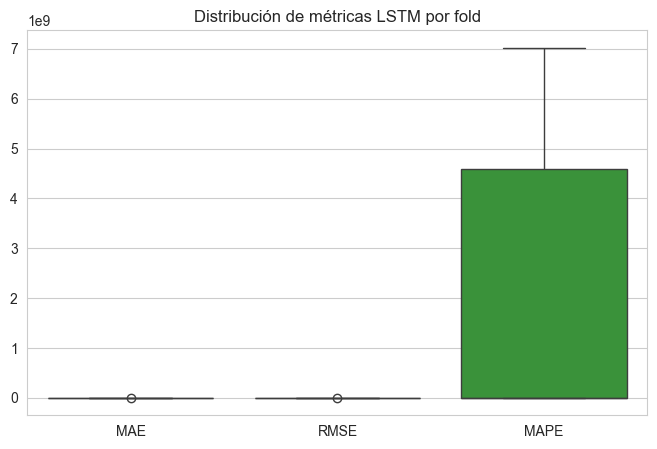

: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# CONFIGURACIÓN BÁSICA
# =============================================================================
n_splits = 5
look_back = 3
TARGET = 'occurrenceCount_publisher'

# =============================================================================
# FUNCIÓN AUXILIAR: Crear secuencias LSTM globales
# =============================================================================
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        X_country = df_country[features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values

        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

# =============================================================================
# FUNCIÓN: Calcular métricas
# =============================================================================
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape}

# =============================================================================
# CREAR SECUENCIAS
# =============================================================================
features_lstm = ['PC1', 'PC2', 'PC3', 'PC4', "pib_per_capita", "gbif_member", "ogp_membership", "superficie_total_km2"]

X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(
    df_featured, features_lstm, TARGET, look_back
)

print(f"✅ Secuencias generadas: {X_seq.shape[0]}")
print(f"Rango de años: {years_seq.min()} - {years_seq.max()}")
print(f"Número de países: {len(np.unique(countries_seq))}")

# =============================================================================
# CROSS VALIDATION TEMPORAL
# =============================================================================
tscv = TimeSeriesSplit(n_splits=n_splits)
unique_years = np.sort(df_featured['year'].unique())
results_lstm = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(unique_years)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")
    train_years = unique_years[train_idx]
    test_years = unique_years[test_idx]

    # Máscaras
    mask_train = np.isin(years_seq, train_years)
    mask_test = np.isin(years_seq, test_years)

    X_train, y_train = X_seq[mask_train], y_seq[mask_train]
    X_test, y_test = X_seq[mask_test], y_seq[mask_test]

    print(f"Train seq: {len(y_train)} | Test seq: {len(y_test)}")

    # Saltar fold si no hay suficientes datos
    if len(y_test) < 3:
        print("⚠️ Muy pocos datos en test, se salta este fold.")
        continue

    # Escalado correcto por fold (fit solo en train)
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[2])
    X_test_flat = X_test.reshape(-1, X_test.shape[2])

    scaler.fit(X_train_flat)
    X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

    # Transformar y (log1p)
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # Modelo LSTM simple
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation="relu", input_shape=(look_back, X_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mae")

    # Entrenamiento
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train_scaled, y_train_log, validation_split=0.1, epochs=50, batch_size=16, verbose=0, callbacks=[es])

    # Predicción
    y_pred_log = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = np.expm1(y_pred_log)  # Volver a escala original

    # Métricas
    metrics = compute_metrics(y_test, y_pred)
    metrics["fold"] = fold + 1
    results_lstm.append(metrics)

    print(f"Fold {fold+1} → MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R2']:.3f}, MAPE: {metrics['MAPE']:.2f}%")

# =============================================================================
# RESULTADOS Y VISUALIZACIÓN
# =============================================================================
results_df = pd.DataFrame(results_lstm)
print("\nResultados globales LSTM:")
print(results_df.describe())

plt.figure(figsize=(8,5))
sns.boxplot(data=results_df[['MAE','RMSE','MAPE']])
plt.title("Distribución de métricas LSTM por fold")
plt.show()



Distribución del TARGET (occurrenceCount_publisher):
count    656.000000
mean      12.537234
std        5.499366
min        0.000000
25%       11.204081
50%       14.290054
75%       16.309018
max       20.582081
Name: occurrenceCount_publisher, dtype: float64


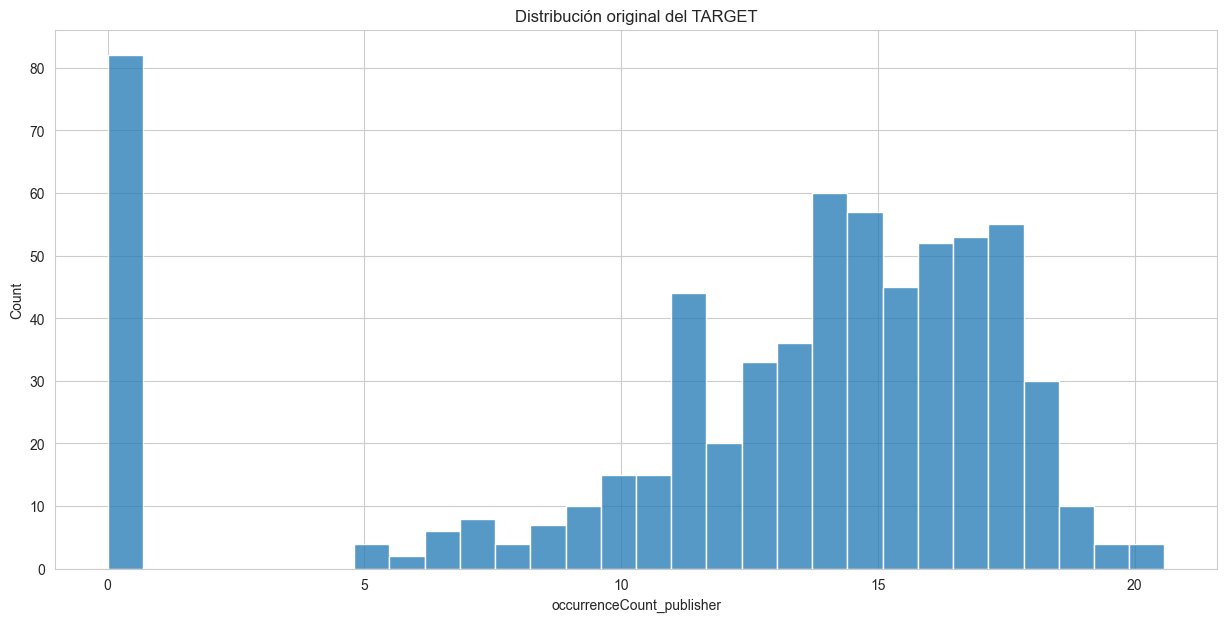

Número de países: 41
Rango de años: 2007 - 2022
count    41.0
mean     16.0
std       0.0
min      16.0
25%      16.0
50%      16.0
75%      16.0
max      16.0
Name: year, dtype: float64
NaN en secuencias LSTM: 0  | En y_seq: 0
               PC1          PC2          PC3          PC4  pib_per_capita  \
count  1599.000000  1599.000000  1599.000000  1599.000000     1599.000000   
mean      0.038145     0.045123    -0.000823     0.010523    30966.714844   
std       2.417112     1.246508     0.981483     0.778076    27602.232422   
min      -3.872488    -4.413805    -1.056901    -2.862347      364.366974   
25%      -1.713972    -0.601293    -0.487503    -0.395795     7366.324463   
50%      -0.578441     0.030592    -0.225037    -0.041921    22442.142578   
75%       1.485097     0.680051     0.213725     0.443456    48642.632812   
max       5.620231     4.425407     6.145605     3.091711   134965.812500   

       gbif_member  ogp_membership  superficie_total_km2  
count  1599.000000 

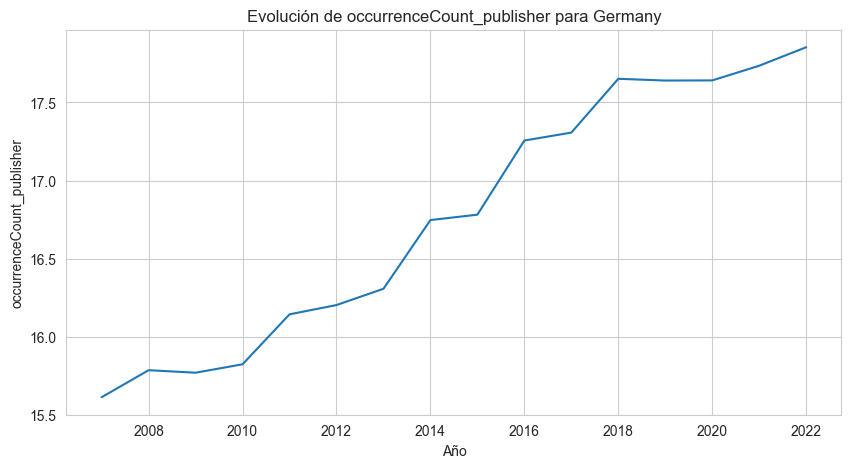

: 

In [ ]:
# ============================================================
# DIAGNÓSTICO DE DATOS Y CONFIGURACIÓN PARA LSTM
# ============================================================

# 1️⃣ Revisar rango y estadísticos del target
print("Distribución del TARGET (occurrenceCount_publisher):")
print(df_featured[TARGET].describe())
sns.histplot(df_featured[TARGET], bins=30)
plt.title("Distribución original del TARGET")
plt.show()

# 2️⃣ Verificar la cantidad de años y países
print(f"Número de países: {df_featured['country'].nunique()}")
print(f"Rango de años: {df_featured['year'].min()} - {df_featured['year'].max()}")
print(df_featured.groupby('country')['year'].nunique().describe())

# 3️⃣ Verificar NaN en las secuencias creadas
print("NaN en secuencias LSTM:", np.isnan(X_seq).sum(), " | En y_seq:", np.isnan(y_seq).sum())

# 4️⃣ Revisar escala de features usados en LSTM
print(pd.DataFrame(X_seq.reshape(-1, X_seq.shape[2]), columns=features_lstm).describe())

# 5️⃣ Visualizar una secuencia ejemplo
sample_country = np.random.choice(df_featured['country'].unique())
df_country = df_featured[df_featured['country'] == sample_country].sort_values('year')
plt.figure(figsize=(10,5))
plt.plot(df_country['year'], df_country[TARGET])
plt.title(f"Evolución de {TARGET} para {sample_country}")
plt.xlabel("Año"); plt.ylabel(TARGET)
plt.show()
